In [63]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from nolitsa import delay
import numpy as np

In [8]:
fs = 1000
dt = 1/fs

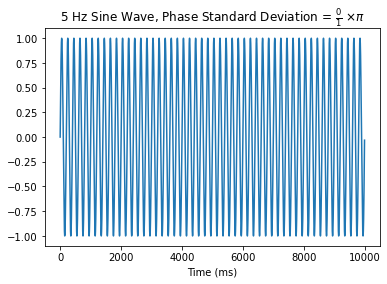

In [10]:
freq = 5 # Hz
duration = 10 # s
length = int(duration*fs)

# construct sin wave
sin_wave = np.zeros(length)
phase_sd = 0
for t in range(length):
    phase = np.random.randn()*phase_sd
    sin_wave[t] = np.sin(2*np.pi*t*dt*freq + phase)
plt.plot(sin_wave)
plt.xlabel("Time (ms)")
integer_ratio = (phase_sd/np.pi).as_integer_ratio()
plt.title(fr"{freq} Hz Sine Wave, Phase Standard Deviation = " + r"$\frac{%d}{%d}$" % integer_ratio + r" $\times \pi$")
plt.show()

In [94]:
signal_in = sin_wave
nlags = min(1000, int(len(signal_in)/2))
bins = 64

# pick tau
delayed_mi = np.zeros(nlags + 1)

n = len(signal_in)

h_x = np.zeros(nlags+1)
h_y = np.zeros(nlags+1)
h_xy = np.zeros(nlags+1)

p_xy_stuff = []
for tau_ in range(nlags + 1):
#     delayed_mi[tau_] = delay.mi(, bins=bins)
    x, y = signal_in[tau_:], signal_in[:n - tau_]
    p_x = np.histogram(x, bins)[0]
    p_y = np.histogram(y, bins)[0]
    p_xy = np.histogram2d(x, y, bins)[0].flatten()
    
    p_x = p_x[p_x > 0] / np.sum(p_x)
    p_y = p_y[p_y > 0] / np.sum(p_y)
    p_xy = p_xy[p_xy > 0] / np.sum(p_xy)
    
    h_x[tau_] = np.sum(p_x * np.log2(p_x))
    h_y[tau_] = np.sum(p_y * np.log2(p_y))
    h_xy[tau_] = np.sum(p_xy * np.log2(p_xy))
    
    p_xy, x_bins, y_bins = np.histogram2d(x, y, bins)
    p_xy = p_xy/ np.sum(p_xy)
    p_xy_stuff.append((p_xy, x_bins, y_bins))

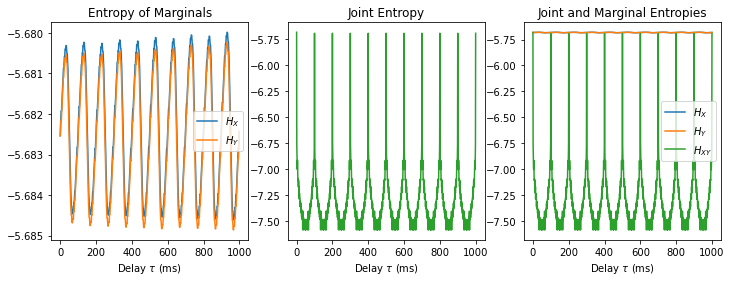

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Entropy of Marginals")
plt.plot(h_x, label='$H_X$')
plt.plot(h_y, label='$H_Y$')
plt.xlabel(r"Delay $\tau$ (ms)")
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Joint Entropy")
plt.plot(h_xy, label='$H_{XY}$', c='C2')
plt.xlabel(r"Delay $\tau$ (ms)")

plt.subplot(1, 3, 3)
plt.title("Joint and Marginal Entropies")
plt.plot(h_x, label='$H_X$')
plt.plot(h_y, label='$H_Y$')
plt.plot(h_xy, label='$H_{XY}$')
plt.xlabel(r"Delay $\tau$ (ms)")
plt.legend()

plt.show()

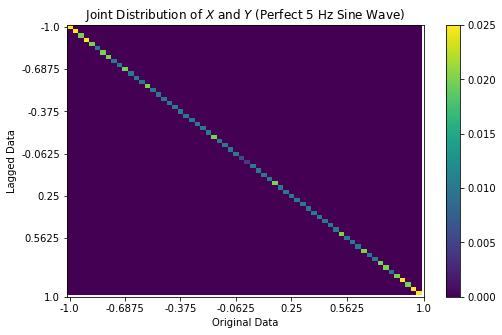

In [119]:
fps = 25
ms_per_frame = 1000/fps
frames_per_image = 2

snapshots = []
for i in range(len(p_xy_stuff)):
    snapshots.extend([p_xy_stuff[i][0]]*frames_per_image)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,5) )

im = plt.imshow(p_xy_stuff[0][0], interpolation='none', aspect='auto', vmin=0, vmax=0.025)
plt.colorbar()
plt.title(f"Joint Distribution of $X$ and $Y$ (Perfect {freq} Hz Sine Wave)")
plt.xlabel("Original Data")
plt.ylabel("Lagged Data")
xtick_locs = plt.xticks()[0][1:-1]
xtick_locs[-1] = bins
plt.xticks(xtick_locs, [p_xy_stuff[0][1][int(loc)] for loc in xtick_locs])
ytick_locs = plt.yticks()[0][1:-1]
ytick_locs[-1] = bins
plt.yticks(ytick_locs, [p_xy_stuff[0][2][int(loc)] for loc in ytick_locs])

def animate_func(i):
    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(snapshots),
                               interval = ms_per_frame, # in ms
                               )

anim.save('/Users/adameisen/Desktop/test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])